# Init

In [5]:
import collections


## Dataset-specific -- edit me
data_number = "082"
data_name = "Final"

treatments = collections.OrderedDict()
treatments['control'] = 'control'
treatments['noreward'] = 'benign'
treatments['punish'] = 'harsh'

## basic config
#base_path = "/home/rosiec/Dropbox/School_Docs/Papers/ALife\ CE\ Paper/alife2016/evo_mod/"
#base_path = "/home/rosiec/Dropbox/School_Docs/Papers/Journal\ CE\ Paper/data_analysis/"
base_path = "/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/"

raw_data_directory = "raw_data"
analysis_directory = "intermediate_data"
scripts_path = "~/Dropbox/School_Docs/Research/research_scripts/"

## generated
data_directory = data_number + "_" + "_".join(data_name.split(" "))
data_path = base_path + raw_data_directory + "/" + data_directory
analysis_path = base_path + analysis_directory

print (data_path)
print (analysis_path)



/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/raw_data/082_Final
/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/intermediate_data


In [6]:
%cd {data_path}
%mkdir {analysis_path}
%cd {analysis_path}
%pwd


/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/raw_data/082_Final
mkdir: cannot create directory ‘/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/intermediate_data’: File exists
/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/intermediate_data


u'/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/intermediate_data'

In [7]:
import glob


import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy  
import scikits.bootstrap as bootstrap
from scipy import stats
import matplotlib.gridspec as gridspec
#from IPython.display import Image
from PIL import Image
from IPython.display import Image as ipyImage

%matplotlib inline
%rehashx
pd.__version__

u'0.20.3'

In [8]:
import sys
sys.path.append({scripts_path})
%run {scripts_path}/quickplot.py --help

Usage: quickplot.py [options] outfile [input_file1 column1 "directory_glob1" name1 .. input_fileN columnN "directory_globN" nameN] 
          


Options:
  -h, --help            show this help message and exit
  -v, --verbose         print extra messages to stdout
  -d, --debug_messages  print debug messages to stdout
  --plotonly            Skip the aggregation step, and plot only, using
                        existing data files.
  --noplot              Skip the plotting step, only aggregate the data files.
  -t TITLE, --title=TITLE
                        set a different title than outfile (default)
  -x XLABEL, --xlabel=XLABEL
                        X-axis Label
  -y YLABEL, --ylabel=YLABEL
                        Y-axis Label
  --include_chevrons    Include line marker glyphs in addition to color
  --chevrons_by_members
                        Make the chevrons track by members, along with line
                        style
  --data_members=MEMBER_COUNT
                        N

# D_g and D_p - Figure 8

## Now to plot out the mutational landscapes
The below items were pre-generated using the collect_and_analyze_mut_networks.py script, which calls Avida with a bunch of parameters. These will, in future, be generated as part of the HPCC data-collection process as an after-step in the population generation. But for now, I generated some by hand.   
    
    
First, we generate the mutational networks.

    rosiec@edi:/Core/home/rosiec/__research/mutational_landscapes/raw_data/201_CyclicCE/network_metrics_dominant/avida_edi$ for i in ../pops/*spop; do time python ../../../../../scripts/project_specific/mutational_landscapes/collect_and_analyze_mut_network.py --verbose --complete -s1 --interconnect -d --environment environment.cfg $i ../networks/$(basename $i).s1_dominant_rewarded.xml; done

    rosiec@edi:/Core/home/rosiec/__research/mutational_landscapes/raw_data/201_CyclicCE/network_metrics_dominant/avida_edi$ for i in ../pops/*noreward*spop; do time python ../../../../../scripts/project_specific/mutational_landscapes/collect_and_analyze_mut_network.py --verbose --complete -s1 --interconnect -d --environment environment_noreward.cfg $i ../networks/$(basename $i).s1_dominant_noreward.xml; done

    rosiec@edi:/Core/home/rosiec/__research/mutational_landscapes/raw_data/201_CyclicCE/network_metrics_dominant/avida_edi$ for i in ../pops/*punish*spop; do time python ../../../../../scripts/project_specific/mutational_landscapes/collect_and_analyze_mut_network.py --verbose --complete -s1 --interconnect -d --environment environment_punish.cfg $i ../networks/$(basename $i).s1_dominant_punished.xml; done

Then, we extract he network metrics that we use to calculate D_p and D_g

    rosiec@edi:/Core/home/rosiec/__research/mutational_landscapes/raw_data/201_CyclicCE/network_metrics_dominant/metrics$ for i in ../networks/*xml; do echo $i; time python ../../../../../scripts/project_specific/mutational_landscapes/collect_network_metrics.py $i > $(basename $i).network_metrics.csv; done    

/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/intermediate_data


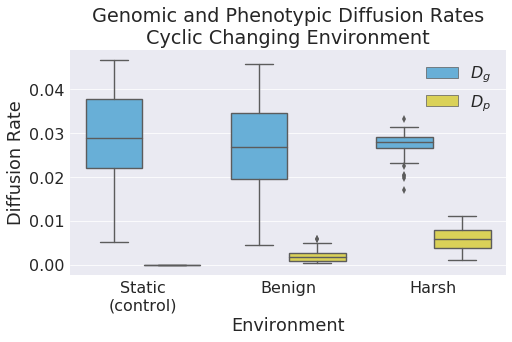

In [13]:
subdir = "../201_CyclicCE/"

tname = {"control": "Static\n(control)",
        "noreward": "Benign",
        "punish": "Harsh"}    
    
## CALCULATE Genomic Diffusion Rate and Phenotypic Diffusion Rate
fields = ["num_cpus", "lethal", "deleterious", "neutral", "beneficial", 
          "same_p_lethal", "same_p_deleterious", "same_p_neutral", "same_p_beneficial", 
          "diff_p_lethal", "diff_p_deleterious", "diff_p_neutral", "diff_p_beneficial"]
## defaults
mu = 0.00075 # per-site copy mutation rate -- R_c in the paper
l = 121 # genome length
D = 26 # inst-set size        
### Fidelity -- probability of birthing a genetically unchanged offspring
F = (1 - mu)**l

dfs = []
dfs_joint = []

for t in treatments:  
    
    D_gs = []
    D_ps = []

    for i in range(1, 50): 
        bit = str(i).zfill(2)
        filepath = data_path + "/" + subdir + "/network_metrics_wholepop/metrics"
        filepath = filepath.replace("\\", "")
        final = filepath + '/*' + t + "*_2010" + bit + '_*.network_metrics.csv'
        
        dfiles = sorted(glob.glob(final))

        D_g_pair = []
        D_p_pair = []
        for item in dfiles:
            dta = pd.read_csv(item, header=None, comment="#", 
                              delimiter=",",
                              skipinitialspace=True, 
                              names=fields, usecols=range(0,len(fields)))
    
            nu_g = np.mean(dta['neutral'] + dta['beneficial'])
            nu_p = np.mean(dta['same_p_neutral'] + dta['same_p_beneficial'])

            f_c_prob_nonneut = mu * (1 - nu_g)
            F_neut = (1 - f_c_prob_nonneut)**l

            f_cp_prob_nonneut_diffphen = mu * (1 - nu_p)
            F_pheno = (1 - f_cp_prob_nonneut_diffphen)**l

            aD_g = F_neut - F
            aD_p = F_neut - F_pheno        

            D_g_pair.append(aD_g)
            D_p_pair.append(aD_p)
            
        if len(dfiles) > 1 or (len(dfiles) == 1 and t == "control"): ## make sure there's something here            
            D_g = np.mean(D_g_pair)
            D_p = np.mean(D_p_pair)

            D_gs.append(D_g)
            D_ps.append(D_p)

    dta = pd.DataFrame()
    dta['Diffusion Rate'] = D_gs
    dta['Metric'] = [r'$D_g$']*len(D_gs)
    dta['Environment'] = [tname[t]]*len(D_gs)    
    dfs.append(dta)

    dta = pd.DataFrame()
    dta['Diffusion Rate'] = D_ps
    dta['Metric'] = [r'$D_p$']*len(D_ps)
    dta['Environment'] = [tname[t]]*len(D_ps)
    dfs.append(dta)
    
diffusion_rates_201_wholepop = pd.concat(dfs, axis=0)
#print diffusion_rates_201_wholepop.head()  
#print diffusion_rates_201_wholepop.tail()  

sns.set(#style="whitegrid", 
    color_codes=True, 
    palette="colorblind")

sns.set_context('paper', font_scale=2)
g = sns.factorplot(x="Environment", y="Diffusion Rate",
                   hue="Metric",
                   data=diffusion_rates_201_wholepop,
                   size=5, aspect=1.5, #
                   palette={r'$D_g$': "c", 
                            r'$D_p$': "y"},
                   kind="box", 
                   legend=False
              )
plt.subplots_adjust(top=0.85)

titles = ["Genomic and Phenotypic Diffusion Rates\nCyclic Changing Environment"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
    
L=plt.legend(loc="upper right")


#plt.show()


!pwd
plt.savefig("CCE_D_g_D_p__box.png", dpi=300)


# sns.set_context('paper', font_scale=2)
# plt.rcParams['figure.figsize'] = (7.5, 5)

# g = sns.violinplot(x="Environment", y="Diffusion Rate",
#                    hue="Metric",
#                    data=diffusion_rates_201_wholepop,
#                    #size=5, aspect=1.5, #
#                    palette={r'$D_g$': "c", 
#                             r'$D_p$': "y"},
#                    #kind="violin", 
#                    #legend=False
#                    scale="count", 
# #                    scale_hue=True, 
#                     bw=.3, 
#                     inner="quart",
#               )
# sns.swarmplot(x="Environment", y="Diffusion Rate",
#                    hue="Metric",
#                    data=diffusion_rates_201_wholepop,
#                    size=5, #aspect=1.5, #
# #                   color="gray",
#                   edgecolor="black",
#                   linewidth=0.5,
#                    palette={r'$D_g$': "r", 
#                             r'$D_p$': "g"},
#                    #kind="violin", 
#                   split = True,
#                    #legend=False,
#               alpha=0.25,
#                 ax=g
#               )
# plt.subplots_adjust(top=0.85)


# #titles = ["Genomic and Phenotypic Diffusion Rates\nStochastic Changing Environment"]
# #for ax, title in zip(g.axes.flat, titles):
# #    ax.set_title(title)
# g.set_title("Genomic and Phenotypic Diffusion Rates\nCyclic Changing Environment")
#     #ax.set_ylim([0,0.35])
#     #ax.set_ylabel("Diffusion Rate")
    
# #L=plt.legend(loc="upper right")#, bbox_to_anchor=(1.05, 1))#bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# handles, labels = ax.get_legend_handles_labels()
# g.legend(handles[:2], labels[:2], loc='upper right')




# plt.show()





# sns.set_context('paper', font_scale=2)
# plt.rcParams['figure.figsize'] = (7.5, 5)

# g = sns.boxplot(x="Environment", y="Diffusion Rate",
#                    hue="Metric",
#                    data=diffusion_rates_201_wholepop,
#                    #size=5, aspect=1.5, #
#                    palette={r'$D_g$': "c", 
#                             r'$D_p$': "y"},
#                    #kind="violin", 
#                    #legend=False
#                    #scale="count", 
# #                    scale_hue=True, 
#                     #bw=.3, 
#                     #inner="quart",
#               )
# sns.swarmplot(x="Environment", y="Diffusion Rate",
#                    hue="Metric",
#                    data=diffusion_rates_201_wholepop,
#                    size=5, #aspect=1.5, #
# #                   color="gray",
#                   edgecolor="black",
#                   linewidth=1,
#                    palette={r'$D_g$': "r", 
#                             r'$D_p$': "g"},
#                    #kind="violin", 
#                   split = True,
#                    #legend=False,
#               alpha=0.25,
#                 ax=g
#               )
# plt.subplots_adjust(top=0.85)


# #titles = ["Genomic and Phenotypic Diffusion Rates\nStochastic Changing Environment"]
# #for ax, title in zip(g.axes.flat, titles):
# #    ax.set_title(title)
# g.set_title("Genomic and Phenotypic Diffusion Rates\nCyclic Changing Environment")
#     #ax.set_ylim([0,0.35])
#     #ax.set_ylabel("Diffusion Rate")
    
# #L=plt.legend(loc="upper right")#, bbox_to_anchor=(1.05, 1))#bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# handles, labels = ax.get_legend_handles_labels()
# g.legend(handles[:2], labels[:2], loc='upper right')


# Stats

In [64]:
def mww(a, b, nameA, nameB, title, field):
    
    a = a.dropna()
    b = b.dropna()
    
    print
    print title + " - " + nameA + " vs " + nameB
    print "-----------------"
    print stats.ranksums(a[field], b[field]) 
    z_stat, p_val = stats.ranksums(a[field], b[field])  

    if p_val < 0.00001:
        p_text = " $<<$ 0.001"
    elif p_val < 0.001:
        p_text = " $<$ 0.001"
    elif p_val < 0.01:
        p_text = " $<$ 0.01"        
    elif p_val < 0.05:
        p_text = " $<$ 0.05"
    else:
        p_text = " = " + str(round(p_val, 2))
        
    #print (z_stat)
    #print (p_val)

    if p_val < (0.05/3): #bonferroni
        print ("reject null of sameness (different)")
    else:
        print ("can't reject null of sameness")
    print "medians"
    #print nameA, a[field].median()
    #print nameB, b[field].median()
    
    sys.stdout.write(nameA + ": ")
    doCI(a[field])
    sys.stdout.write(nameB + ": ")
    doCI(b[field])
    
    print "(Wilcoxon Rank Sum Test: Z = " + str(round(z_stat, 2)) + ", p" + p_text + ")"

def kruskal(a, b, c, field=None, verbose=False):
    x = a[field].dropna()
    y = b[field].dropna()
    z = c[field].dropna()    

    if verbose:
        print a[field].describe()
        print b[field].describe()
        print c[field].describe()
        print
        print x
        print y
        print z
    
    #vals = stats.kruskal(x, y, z)
    
    h2_stat, p_val = stats.kruskal(x, y, z)

    if p_val < 0.00001:
        p_text = " $<<$ 0.001"
    elif p_val < 0.001:
        p_text = " $<$ 0.001"
    elif p_val < 0.01:
        p_text = " $<$ 0.01"        
    elif p_val < 0.05:
        p_text = " $<$ 0.05"
    else:
        p_text = " = " + str(round(p_val, 2))
    
    print stats.kruskal(x, y, z)
#    (Kruskal Wallis: H(2) = 1.4, p = 0.48)
    print "(Kruskal Wallis: H(2) = " + str(round(h2_stat, 2)) + ", p" + p_text + ")"
    
def medianCI(data, ci=0.95, p=0.5):    
    '''
    From https://github.com/minddrummer/median-confidence-interval/blob/master/Median_CI.py
    data: pandas datafame/series or numpy array
    ci: confidence level
    p: percentile' percent, for median it is 0.5
    output: a list with two elements, [lowerBound, upperBound]
    '''
    if type(data) is pd.Series or type(data) is pd.DataFrame:
        #transfer data into np.array
        data = data.values

    #flat to one dimension array
    data = data.reshape(-1)
    data = np.sort(data)
    N = data.shape[0]
    
    lowCount, upCount = stats.binom.interval(ci, N, p, loc=0)
    #given this: https://onlinecourses.science.psu.edu/stat414/node/316
    #lowCount and upCount both refers to  W's value, W follows binomial Dis.
    #lowCount need to change to lowCount-1, upCount no need to change in python indexing
    lowCount -= 1
    # print lowCount, upCount
    return data[int(lowCount)], data[int(upCount)]  

def doCI(data):
    
    low, high = medianCI(data)
    
    med = data.median()
    
    print "(Mdn = " +str(round(med, 2))+ ", CI 95\% [" + str(round(low, 2)) + ", " + str(round(high, 2)) + "])"
    print " --- (Mdn = " +str(round(med, 4))+ ", CI 95\% [" + str(round(low, 4)) + ", " + str(round(high, 4)) + "])"
    
def corr(a, b, nameA, nameB, title, fieldA, fieldB):
    print
    print title + " - " + nameA + " vs " + nameB
    print "-----------------"
#     print stats.ranksums(a[field], b[field]) 
#     z_stat, p_val = stats.ranksums(a[field], b[field])  
    
    correlation = ss.pearsonr(a[fieldA], b[fieldB])

    from decimal import Decimal

    #r2 = '%.2E' % Decimal(correlation[0])
    p = '%.2E' % Decimal(correlation[1])
    
    p_val = correlation[1]

    #ann = "$r_{2}$ = " + str(round(correlation[0], 2)) + "\n" + "$p$ = " + p

    if p_val < 0.00001:
        p_text = " $<<$ 0.001"
    elif p_val < 0.001:
        p_text = " < 0.001"
    elif p_val < 0.01:
        p_text = " < 0.01"        
    elif p_val < 0.05:
        p_text = " $<$ 0.05"
    else:
        p_text = " = " + str(round(p_val, 2))
        
    print "(Pearson's R: $r_{2}$ = " + str(round(correlation[0], 2)) + ", p = " + p_text + ")"   
        
    #print (z_stat)
    #print (p_val)

#     if p_val < (0.05/3): #bonferroni
#         print ("reject null of sameness (different)")
#     else:
#         print ("can't reject null of sameness")
    print "medians"
    print nameA, a[fieldA].median()
    print nameB, b[fieldB].median()
    
#    print "(Wilcoxon Rank Sum Test: Z = " + str(round(z_stat, 2)) + ", p" + p_text + ")"

In [28]:
print diffusion_rates_201_wholepop.head()

   Diffusion Rate Metric        Environment
0        0.021873  $D_g$  Static\n(control)
1        0.017177  $D_g$  Static\n(control)
2        0.023240  $D_g$  Static\n(control)
3        0.037189  $D_g$  Static\n(control)
4        0.023834  $D_g$  Static\n(control)


In [65]:
dat = diffusion_rates_201_wholepop.loc[diffusion_rates_201_wholepop['Metric'] == '$D_p$']

a = dat.loc[dat['Environment'] == 'Static\n(control)'].dropna()
b = dat.loc[dat['Environment'] == 'Benign'].dropna()
c = dat.loc[dat['Environment'] == 'Harsh'].dropna()

print a.head()
print b.head()
print c.head()

   Diffusion Rate Metric        Environment
0             0.0  $D_p$  Static\n(control)
1             0.0  $D_p$  Static\n(control)
2             0.0  $D_p$  Static\n(control)
3             0.0  $D_p$  Static\n(control)
4             0.0  $D_p$  Static\n(control)
   Diffusion Rate Metric Environment
0        0.000388  $D_p$      Benign
1        0.000467  $D_p$      Benign
2        0.005763  $D_p$      Benign
3        0.001726  $D_p$      Benign
4        0.001816  $D_p$      Benign
   Diffusion Rate Metric Environment
0        0.007489  $D_p$       Harsh
1        0.004694  $D_p$       Harsh
2        0.002879  $D_p$       Harsh
3        0.005994  $D_p$       Harsh
4        0.001006  $D_p$       Harsh


In [66]:
mww(a, b, "Static", 'Benign', '$D_p$', 'Diffusion Rate')
mww(a, c, "Static", 'Harsh', '$D_p$', 'Diffusion Rate')



$D_p$ - Static vs Benign
-----------------
RanksumsResult(statistic=-8.0184446462798853, pvalue=1.0709252390171238e-15)
reject null of sameness (different)
medians
Static: (Mdn = 0.0, CI 95\% [0.0, 0.0])
 --- (Mdn = 0.0, CI 95\% [0.0, 0.0])
Benign: (Mdn = 0.0, CI 95\% [0.0, 0.0])
 --- (Mdn = 0.0018, CI 95\% [0.0012, 0.0023])
(Wilcoxon Rank Sum Test: Z = -8.02, p $<<$ 0.001)

$D_p$ - Static vs Harsh
-----------------
RanksumsResult(statistic=-8.392705165797258, pvalue=4.7508194626989813e-17)
reject null of sameness (different)
medians
Static: (Mdn = 0.0, CI 95\% [0.0, 0.0])
 --- (Mdn = 0.0, CI 95\% [0.0, 0.0])
Harsh: (Mdn = 0.01, CI 95\% [0.0, 0.01])
 --- (Mdn = 0.0059, CI 95\% [0.0047, 0.0075])
(Wilcoxon Rank Sum Test: Z = -8.39, p $<<$ 0.001)


In [62]:
dat = diffusion_rates_201_wholepop.loc[diffusion_rates_201_wholepop['Metric'] == '$D_g$']

a = dat.loc[dat['Environment'] == 'Static\n(control)'].dropna()
b = dat.loc[dat['Environment'] == 'Benign'].dropna()
c = dat.loc[dat['Environment'] == 'Harsh'].dropna()

print a.head()
print b.head()
print c.head()

   Diffusion Rate Metric        Environment
0        0.021873  $D_g$  Static\n(control)
1        0.017177  $D_g$  Static\n(control)
2        0.023240  $D_g$  Static\n(control)
3        0.037189  $D_g$  Static\n(control)
4        0.023834  $D_g$  Static\n(control)
   Diffusion Rate Metric Environment
0        0.019466  $D_g$      Benign
1        0.026137  $D_g$      Benign
2        0.032421  $D_g$      Benign
3        0.022156  $D_g$      Benign
4        0.021485  $D_g$      Benign
   Diffusion Rate Metric Environment
0        0.029034  $D_g$       Harsh
1        0.028257  $D_g$       Harsh
2        0.027879  $D_g$       Harsh
3        0.027248  $D_g$       Harsh
4        0.027331  $D_g$       Harsh


In [63]:
kruskal(a, b, c, "Diffusion Rate")

KruskalResult(statistic=1.4350489443016272, pvalue=0.48795871742360741)
(Kruskal Wallis: H(2) = 1.44, p = 0.49)
